<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [48]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [49]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-04 19:11:09--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2020-08-04 19:11:09 (15.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [50]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [51]:
df.shape

(346, 10)

### Convert to date time object 

In [52]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [53]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [54]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



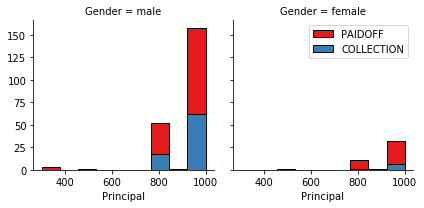

In [55]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

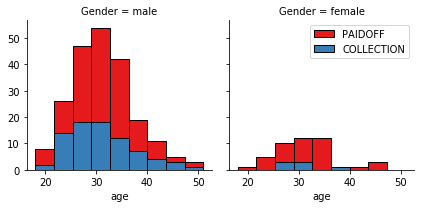

In [56]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

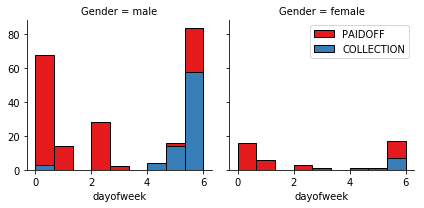

In [57]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [58]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [59]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [60]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [61]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [62]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [63]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [64]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [65]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [66]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

### Train Test Dataset Split

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


### Data Standardization - done after train test split

In [68]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
X[0:5]
X = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))
X[0:5]

array([[ 0.33474248,  0.83916906, -0.19614926, -0.47756693,  0.74535599,
        -0.2773501 ,  1.26197963, -1.05887304],
       [-1.70282047, -0.9301633 , -0.19614926, -0.47756693,  0.74535599,
        -0.2773501 , -0.79240582,  0.94440028],
       [ 0.33474248, -0.9301633 , -0.04012144, -0.47756693, -1.34164079,
        -0.2773501 ,  1.26197963, -1.05887304],
       [ 0.33474248,  0.83916906, -1.13231619, -0.47756693, -1.34164079,
        -0.2773501 , -0.79240582,  0.94440028],
       [ 0.33474248,  0.83916906,  0.42796202, -0.47756693, -1.34164079,
        -0.2773501 , -0.79240582,  0.94440028]])

### To implement kNN, let's first find the best k value to use

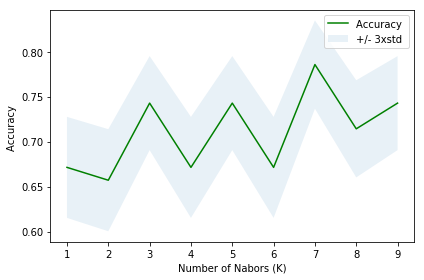

The best accuracy was with 0.7857142857142857 with k= 7


In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

## We can see k=7 is the most accurate. Let's run kNN using k=7

In [71]:
k = 7
neigh7 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat7 = neigh7.predict(X_test)
neigh7

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [72]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh7.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat7))

Train set Accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857


# Decision Tree

In [73]:
#import Decision Tree Classifier from sklearn
from sklearn.tree import DecisionTreeClassifier

In [80]:
#We can run the Decision Tree for a range of max_depth values to see which depth value provides the most accurate result.
dRange = range(1,15)
accuracy = []

for d in dRange:
    deTree = DecisionTreeClassifier(criterion="entropy", max_depth = d)
    deTree.fit(X_train, y_train)
    predTree = deTree.predict(X_test)
    print("Max_depth: ", d,  " DecisionTree Accuracy: ", metrics.accuracy_score(y_test, predTree))


Max_depth:  1  DecisionTree Accuracy:  0.7857142857142857
Max_depth:  2  DecisionTree Accuracy:  0.7857142857142857
Max_depth:  3  DecisionTree Accuracy:  0.6142857142857143
Max_depth:  4  DecisionTree Accuracy:  0.6142857142857143
Max_depth:  5  DecisionTree Accuracy:  0.6428571428571429
Max_depth:  6  DecisionTree Accuracy:  0.7714285714285715
Max_depth:  7  DecisionTree Accuracy:  0.7571428571428571
Max_depth:  8  DecisionTree Accuracy:  0.7571428571428571
Max_depth:  9  DecisionTree Accuracy:  0.6571428571428571
Max_depth:  10  DecisionTree Accuracy:  0.7
Max_depth:  11  DecisionTree Accuracy:  0.7
Max_depth:  12  DecisionTree Accuracy:  0.7
Max_depth:  13  DecisionTree Accuracy:  0.7
Max_depth:  14  DecisionTree Accuracy:  0.7285714285714285


In [76]:
# Reviewing the results, the most accurate tree with least complexity with is depth 1. We could also model the tree for depth 6 and compare if we wanted more nodes in the tree.
dTree1 = DecisionTreeClassifier(criterion="entropy", max_depth = 1)
dTree1

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [78]:
dTree1.fit(X_train, y_train)
predTree1 = dTree1.predict(X_test)

In [81]:
#max_depth=6
dTree6 = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
dTree6

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Support Vector Machine

In [91]:
#Let's run a for-loop to figure out what kernel function results in the highest accuracy. We can then run SVM using that function.

from sklearn import svm
# f1_score and jaccard index
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score


kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']
f_score = []

for n in kernel_list:
    clf = svm.SVC(kernel=n)
    clf.fit(X_train, y_train) 
    yhat = clf.predict(X_test)
    
    f_score.append(f1_score(y_test, yhat, average='weighted'))
    
f_score

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.6914285714285714,
 0.7064793130366899,
 0.7275882012724117,
 0.6892857142857144]

### Running the above SVM for loop, we can see that the highest accuracy occurs when the kernel is set to rbf (.727). 

In [92]:
#SVM using rbf kernel function
SVM_rbf = svm.SVC(kernel='rbf')
SVM_rbf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [93]:
#We can use the model to predict new values
yhat_rbf = SVM_rbf.predict(X_test)
yhat_rbf [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Logistic Regression

In [94]:
import scipy.optimize as opt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss


In [103]:
#Let's run a for loop to assess various C and solver values. We'll use log_loss as our metric, since it measures the performance of a classifier with prob btwn 0 and 1.

c_range = [0.001, 0.01, 0.1]
solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for n, c in enumerate(c_range):
    for m, solve in enumerate(solver_list):
        
        LR = LogisticRegression(C=c, solver=solve).fit(X_train,y_train)
        
        yhat = LR.predict(X_test)
        yhat_prob = LR.predict_proba(X_test)
        logLoss = log_loss(y_test, yhat_prob)
    
        print("C value: ", c, "Solver: ", solve, "LogLoss: : %.2f" % logLoss)

C value:  0.001 Solver:  newton-cg LogLoss: : 0.52
C value:  0.001 Solver:  lbfgs LogLoss: : 0.52
C value:  0.001 Solver:  liblinear LogLoss: : 0.67
C value:  0.001 Solver:  sag LogLoss: : 0.52
C value:  0.001 Solver:  saga LogLoss: : 0.52
C value:  0.01 Solver:  newton-cg LogLoss: : 0.49
C value:  0.01 Solver:  lbfgs LogLoss: : 0.49
C value:  0.01 Solver:  liblinear LogLoss: : 0.58
C value:  0.01 Solver:  sag LogLoss: : 0.49
C value:  0.01 Solver:  saga LogLoss: : 0.49
C value:  0.1 Solver:  newton-cg LogLoss: : 0.48
C value:  0.1 Solver:  lbfgs LogLoss: : 0.48
C value:  0.1 Solver:  liblinear LogLoss: : 0.50
C value:  0.1 Solver:  sag LogLoss: : 0.48
C value:  0.1 Solver:  saga LogLoss: : 0.48


### The results indicate the largest logLoss value when using c = 0.001 and solver = liblinear. Let's run LR using those parameters.

In [139]:
LR2 = LogisticRegression(C=0.001, solver='liblinear').fit(X_train,y_train)
yhat2 = LR2.predict(X_test)
yhat_prob2 = LR2.predict_proba(X_test)
LR2

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# Model Evaluation using Test set

In [106]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [107]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-08-04 20:03:03--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-08-04 20:03:03 (342 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [134]:
test_df1 = pd.read_csv('loan_test.csv')
test_df1.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [135]:
test_df1.shape

(54, 10)

In [136]:
#Now let's prep the test set df
#datetime
test_df1['due_date'] = pd.to_datetime(test_df1['due_date'])
test_df1['effective_date'] = pd.to_datetime(test_df1['effective_date'])
test_df1['dayofweek'] = test_df1['effective_date'].dt.dayofweek

#day of week threshold value
test_df1['weekend'] = test_df1['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

#convert categorical to numerical
test_df1['Gender'].replace(to_replace=['male','female'],value=[0,1],inplace=True)

#similar to previous data set
testFeature = test_df1[['Principal','terms','age','Gender','weekend']]
testFeature = pd.concat([testFeature,pd.get_dummies(test_df1['education'])], axis=1)
testFeature.drop(['Master or Above'], axis = 1,inplace=True)

#define and normalize
X_loantest = testFeature
X_loantest = preprocessing.StandardScaler().fit(X_loantest).transform(X_loantest)
y_loantest = test_df1['loan_status'].values

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:20: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [137]:
X_loantest[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [138]:
y_loantest[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### Let's check the accuracy of built model using different evaluation metrics and algorithms
##### Note: Values obtained are from the assumed "best model setups" in Part 1. Different values will be found if the model setups are changed.

In [154]:
#Jaccard
from sklearn.metrics import jaccard_similarity_score
#F1-score
from sklearn.metrics import f1_score
#logLoss
from sklearn.metrics import log_loss

#kNN
yhat7 = neigh7.predict(X_loantest)
j1 = round(jaccard_similarity_score(y_loantest, yhat7), 2)
f1 = round(f1_score(y_loantest, yhat7, average='weighted') , 2)

#Decision Tree
predTree1 = dTree1.predict(X_loantest)
j2 = round(jaccard_similarity_score(y_loantest, predTree1), 2)
f2 = round(f1_score(y_loantest, predTree1, average='weighted') , 2)

#SVM
yhat_rbf = SVM_rbf.predict(X_loantest)
j3 = round(jaccard_similarity_score(y_loantest, yhat_rbf), 2)
f3 = round(f1_score(y_loantest, yhat_rbf, average='weighted') , 2)

#LR
yhat2 = LR2.predict(X_loantest)
j4 = round(jaccard_similarity_score(y_loantest, yhat2), 2)
f4 = round(f1_score(y_loantest, yhat2, average='weighted') , 2)
yhat_prob2 = LR2.predict_proba(X_loantest)
l4 = round(log_loss(y_loantest, yhat_prob2), 2)


#Let's create lists to store our results
j_list = [j1, j2, j3, j4]

f_list = [f1, f2, f3, f4]

l_list = ['NA','NA','NA',l4]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Now let's build our table and fill in the missing data

In [159]:
table_df = pd.DataFrame(j_list, index=['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'])
table_df.columns = ['Jaccard']
table_df.columns.name = 'Algorithm'
table_df.insert(loc=1, column='F1-score', value=f_list)
table_df.insert(loc=2, column='LogLoss', value=l_list)
table_df

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.67,0.63,NA
Decision Tree,0.74,0.63,NA
SVM,0.80,0.76,NA
LogisticRegression,0.78,0.73,0.67


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>